In [10]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [11]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [36]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 2 methods)

In [13]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [45]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [40]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [41]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [42]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [19]:
############
#Read in the demand file
file = open("../data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [20]:
demands

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 300.0
  (8,23)  => 300.0
  (6,9)   => 400.0
  (18,3)  => 0.0
  (21,13) => 600.0
  (22,16) => 1200.0
  (15,17) => 1500.0
  (22,14) => 1200.0
  (13,9)  => 600.0
  (23,10) => 1800.0
  (24,22) => 1100.0
  (8,9)   => 800.0
  (9,1)   => 500.0
  (17,14) => 700.0
  (16,6)  => 900.0
  (16,12) => 700.0
  (16,13) => 600.0
  (22,2)  => 100.0
  (24,3)  => 0.0
  (7,16)  => 1400.0
  (1,12)  => 200.0
  (4,5)   => 500.0
  (11,8)  => 800.0
  (18,21) => 100.0
  (19,4)  => 200.0
  ⋮       => ⋮

In [21]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix.txt")
OD_demands_dict = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    OD_demands_dict[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    OD_demands_dict[key] = value
end
close(file)

In [22]:
OD_demands_dict

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 182384.986236
  (4,4) => 0.0
  (3,1) => 2.0e-6
  (4,5) => 5.8e-5
  (2,4) => 91544.578091
  (6,5) => 84395.666024
  (8,4) => 136923.111313
  (1,2) => 0.0
  (5,1) => 183507.058434
  (3,4) => 2.0e-6
  (8,2) => 3.0e-6
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 35254.639442
  (2,1) => 120303.689693
  (2,5) => 0.0
  (8,5) => 80837.143914
  (1,4) => 121387.828328
  (2,8) => 0.0
  (5,8) => 80908.970467
  (4,8) => 120195.116918
  (7,8) => 6083.246567
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 1.0e-6
  ⋮     => ⋮

In [25]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [26]:
arcs

Dict{(Int64,Int64),Arc} with 76 entries:
  (15,19) => Arc(15,19,14564.75315,3.0,0.0)
  (20,21) => Arc(20,21,5059.91234,6.0,0.0)
  (22,20) => Arc(22,20,5075.697193,5.0,0.0)
  (23,22) => Arc(23,22,5000.0,4.0,0.0)
  (10,11) => Arc(10,11,10000.0,5.0,0.0)
  (8,9)   => Arc(8,9,5050.193156,10.0,0.0)
  (13,12) => Arc(13,12,25900.20064,3.0,0.0)
  (24,21) => Arc(24,21,4885.357564,3.0,0.0)
  (3,1)   => Arc(3,1,23403.47319,4.0,0.0)
  (19,17) => Arc(19,17,4823.950831,2.0,0.0)
  (4,5)   => Arc(4,5,17782.7941,2.0,0.0)
  (17,16) => Arc(17,16,5229.910063,2.0,0.0)
  (20,22) => Arc(20,22,5075.697193,5.0,0.0)
  (22,21) => Arc(22,21,5229.910063,2.0,0.0)
  (18,16) => Arc(18,16,19679.89671,3.0,0.0)
  (6,5)   => Arc(6,5,4947.995469,4.0,0.0)
  (16,17) => Arc(16,17,5229.910063,2.0,0.0)
  (22,15) => Arc(22,15,9599.180565,3.0,0.0)
  (1,2)   => Arc(1,2,25900.20064,6.0,0.0)
  (22,23) => Arc(22,23,5000.0,4.0,0.0)
  (19,20) => Arc(19,20,5002.607563,4.0,0.0)
  (9,8)   => Arc(9,8,5050.193156,10.0,0.0)
  (11,12) => Arc(

In [28]:
###########
#read in the flows
file = open("../data_original/SiouxFallsFlow.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

In [50]:
arcs

Dict{(Int64,Int64),Arc} with 76 entries:
  (15,19) => Arc(15,19,14564.75315,3.0,19083.289764747366)
  (20,21) => Arc(20,21,5059.91234,6.0,6302.022874186994)
  (22,20) => Arc(22,20,5075.697193,5.0,7000.0)
  (23,22) => Arc(23,22,5000.0,4.0,9626.21020048335)
  (10,11) => Arc(10,11,10000.0,5.0,17726.62503296105)
  (8,9)   => Arc(8,9,5050.193156,10.0,6882.664912661778)
  (13,12) => Arc(13,12,25900.20064,3.0,12378.642039980477)
  (24,21) => Arc(24,21,4885.357564,3.0,10259.524716223794)
  (3,1)   => Arc(3,1,23403.47319,4.0,8094.6576464564205)
  (19,17) => Arc(19,17,4823.950831,2.0,9941.856797956832)
  (4,5)   => Arc(4,5,17782.7941,2.0,18006.371019862527)
  (17,16) => Arc(17,16,5229.910063,2.0,11683.838282439508)
  (20,22) => Arc(20,22,5075.697193,5.0,7000.0)
  (22,21) => Arc(22,21,5229.910063,2.0,8607.387929735014)
  (18,16) => Arc(18,16,19679.89671,3.0,15333.406655753832)
  (6,5)   => Arc(6,5,4947.995469,4.0,8806.498666814754)
  (16,17) => Arc(16,17,5229.910063,2.0,11695.002916533696)
  (22,

In [29]:
##########
#Generate the simulated data
##########
numData = 1; sigma = .0

flow_data = Array(Float64, length(arcs), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end
    
    flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
end

In [46]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [47]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 576 entries:
  (23,8)  => [300.0]
  (8,23)  => [300.0]
  (6,9)   => [400.0]
  (18,3)  => [0.0]
  (21,13) => [600.0]
  (22,16) => [1200.0]
  (15,17) => [1500.0]
  (22,14) => [1200.0]
  (13,9)  => [600.0]
  (23,10) => [1800.0]
  (24,22) => [1100.0]
  (8,9)   => [800.0]
  (9,1)   => [500.0]
  (17,14) => [700.0]
  (16,6)  => [900.0]
  (16,12) => [700.0]
  (16,13) => [600.0]
  (22,2)  => [100.0]
  (24,3)  => [0.0]
  (7,16)  => [1400.0]
  (1,12)  => [200.0]
  (4,5)   => [500.0]
  (11,8)  => [800.0]
  (18,21) => [100.0]
  (19,4)  => [200.0]
  ⋮       => ⋮

In [48]:
#include("trafficCval.jl")

arcs3 = arcs
arcs4 = arcs
arcs5 = arcs
arcs6 = arcs
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 3
deg = 3
c = 3.41
lam = 1.

fcoeffs3 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs3)
coeffs_dict[(deg, c, lam)] = fcoeffs3

# deg = 4
deg = 4
c = 3.41
lam = 1.

fcoeffs4 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs4)
coeffs_dict[(deg, c, lam)] = fcoeffs4

# deg = 5
deg = 5
c = 2.6
lam = .1

fcoeffs5 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs5)
coeffs_dict[(deg, c, lam)] = fcoeffs5

# deg = 6
deg = 6
c = 2.6
lam = 1e-3

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

0.09908094585899475
0.0010841282667550835
3.8080352882642826e-5
-3.984159593631967e-6


7-element Array{Float64,1}:
  0.999952   
  0.000388676
 -0.000946889
  0.00104191 
  0.149417   
  0.000163232
 -1.81572e-5 

INFO: Loading help data...


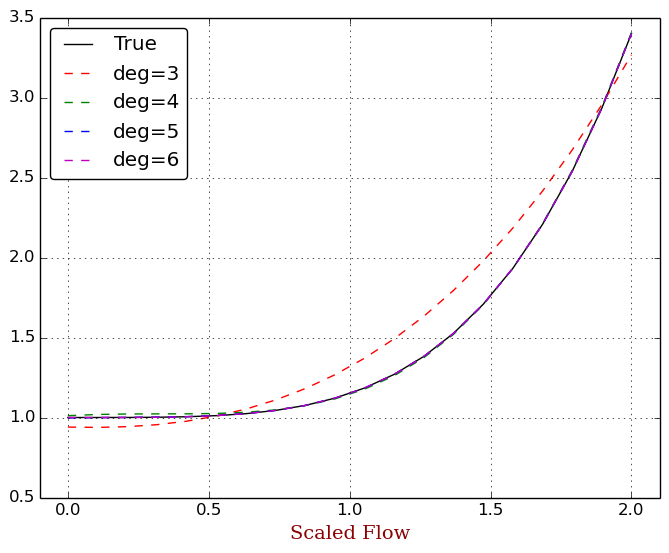

In [49]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]
fcoeffs3 = coeffs_dict[(3, 3.41, 1.)]
fcoeffs4 = coeffs_dict[(4, 3.41, 1.)]
fcoeffs5 = coeffs_dict[(5, 2.6, .1)]
fcoeffs6 = coeffs_dict[(6, 2.6, 1e-3)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys3 = map(x->polyEval(fcoeffs3, x), xs)
ys4 = map(x->polyEval(fcoeffs4, x), xs)
ys5 = map(x->polyEval(fcoeffs5, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys_true, "k", label="True")
plot(xs, ys3, "--r", label="deg=3")
plot(xs, ys4, "--g", label="deg=4")
plot(xs, ys5, "--b", label="deg=5")
plot(xs, ys6, "--m", label="deg=6")
legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.1);
ylim(0.5, 3.5);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("fitting.pdf")